In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

Total records in sfrs (before filtering by image/spectrum): 4851200
Total records after filtering by image/spectrum availability: 151190
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841
Among them, FLAG != 0: 13911


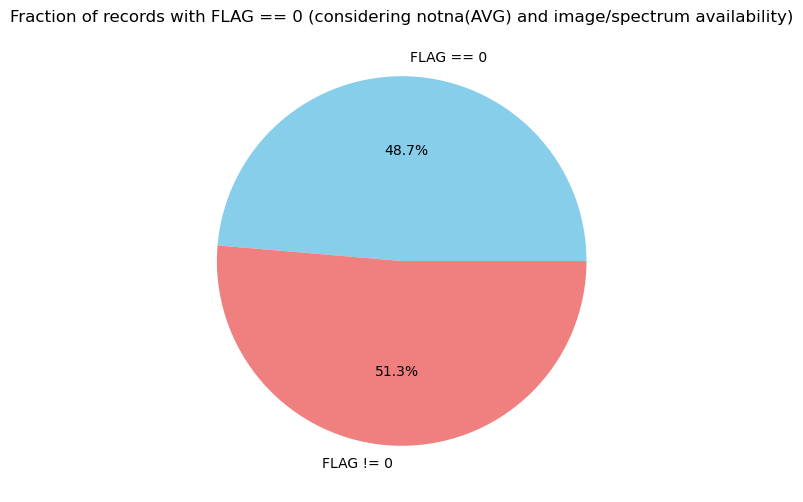

In [3]:
print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))

sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
print("Total records after filtering by image/spectrum availability:", len(sfrs))

sfrs = sfrs[sfrs["AVG"].notna()].copy()
print("Total records after removing NaN in AVG:", len(sfrs))

sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))

sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
sfrs_flag_not0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] != 0.0].copy()
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))
print("Among them, FLAG != 0:", len(sfrs_flag_not0_filtered))

sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=["skyblue", "lightcoral"])
plt.title("Fraction of records with FLAG == 0 (considering notna(AVG) and image/spectrum availability)")
plt.show()

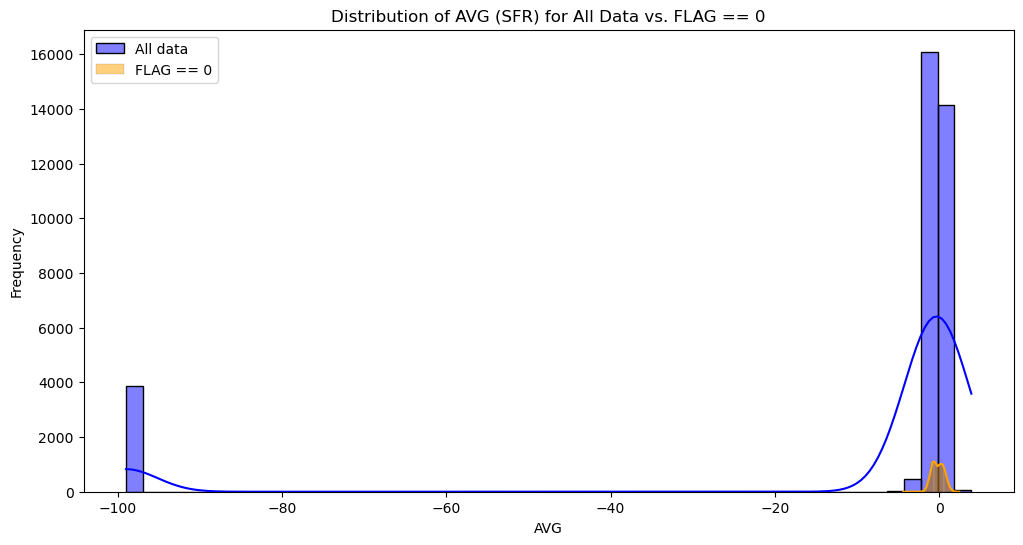

In [4]:
plt.figure(figsize=(12,6))
sns.histplot(sfrs["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

After filtering AVG>=-80: total 30752, among them FLAG==0: 16841


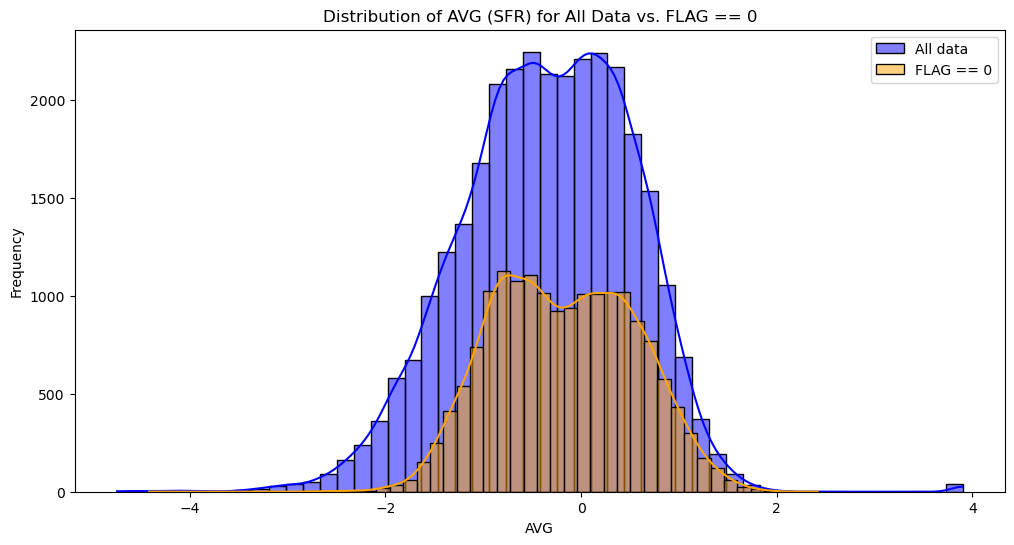

In [5]:
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print(f"After filtering AVG>=-80: total {len(sfrs_filtered)}, among them FLAG==0: {len(sfrs_flag0_filtered)}")

plt.figure(figsize=(12,6))
sns.histplot(sfrs_filtered["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0_filtered["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

In [6]:
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)           
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)      

all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("Filtered images shape (quality 0):", filtered_images[0].shape)
print("Filtered images shape (quality 1):", filtered_images[1].shape)
print("Filtered images shape (quality 2):", filtered_images[2].shape)
print("Filtered images shape (quality 3):", filtered_images[3].shape)

print("Filtered spectra shape (quality 0):", filtered_spectra[0].shape)
print("Filtered spectra shape (quality 1):", filtered_spectra[1].shape)
print("Filtered spectra shape (quality 2):", filtered_spectra[2].shape)
print("Filtered spectra shape (quality 3):", filtered_spectra[3].shape)

Filtered images shape (quality 0): (16841, 5, 64, 64)
Filtered images shape (quality 1): (16841, 5, 32, 32)
Filtered images shape (quality 2): (16841, 5, 16, 16)
Filtered images shape (quality 3): (16841, 5, 8, 8)
Filtered spectra shape (quality 0): (16841, 4620)
Filtered spectra shape (quality 1): (16841, 2310)
Filtered spectra shape (quality 2): (16841, 1155)
Filtered spectra shape (quality 3): (16841, 577)


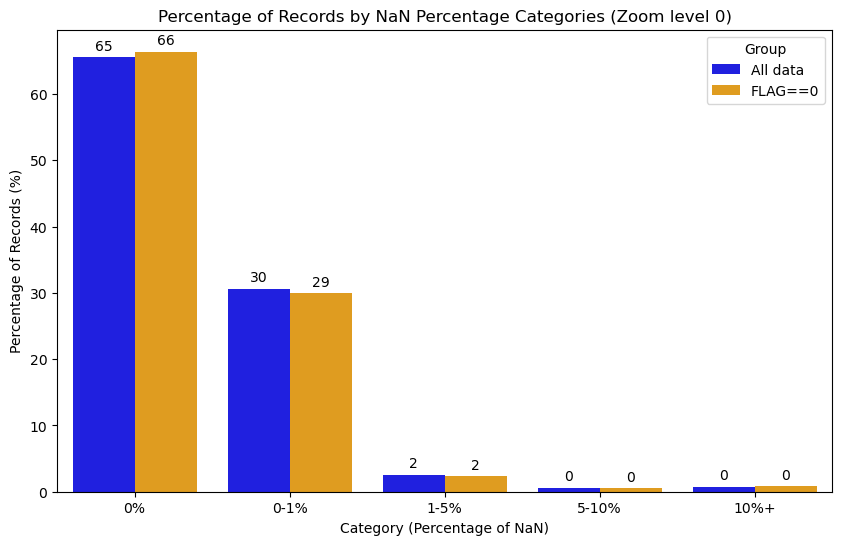

In [7]:
nan_counts_all = np.sum(np.isnan(all_spectra[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(filtered_spectra[0]), axis=1)
total_length = all_spectra[0].shape[1]

def categorize_nan_percentage(nan_counts, total_length):
    percentages = (nan_counts / total_length) * 100
    categories = []
    for p in percentages:
        if p == 0:
            categories.append("0%")
        elif p <= 1:
            categories.append("0-1%")
        elif p <= 5:
            categories.append("1-5%")
        elif p <= 10:
            categories.append("5-10%")
        else:
            categories.append("10%+")
    return categories

categories_all = categorize_nan_percentage(nan_counts_all, total_length)
categories_flag0 = categorize_nan_percentage(nan_counts_flag0, total_length)

df_all = pd.DataFrame({"NaN_Category": categories_all, "Group": "All data"})
df_flag0 = pd.DataFrame({"NaN_Category": categories_flag0, "Group": "FLAG==0"})
df_nan = pd.concat([df_all, df_flag0], ignore_index=True)

category_order = ["0%", "0-1%", "1-5%", "5-10%", "10%+"]

grouped = df_nan.groupby(["Group", "NaN_Category"]).size().reset_index(name="count")
total_counts_df = df_nan.groupby("Group").size().reset_index(name="total")
merged = pd.merge(grouped, total_counts_df, on="Group")
merged["percent"] = merged["count"] / merged["total"] * 100

merged["NaN_Category"] = pd.Categorical(merged["NaN_Category"], categories=category_order, ordered=True)
merged = merged.sort_values(["Group", "NaN_Category"])

plt.figure(figsize=(10,6))
ax = sns.barplot(data=merged, x="NaN_Category", y="percent", hue="Group", 
                 order=category_order, palette=["blue", "orange"])
plt.title("Percentage of Records by NaN Percentage Categories (Zoom level 0)")
plt.xlabel("Category (Percentage of NaN)")
plt.ylabel("Percentage of Records (%)")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.show()

Zoom level 0 (FLAG == 0): found 12207 NaN blocks, average length = 34.69, max = 4620
Zoom level 0 (FLAG != 0): found 24076 NaN blocks, average length = 31.97, max = 4620
Zoom level 1 (FLAG == 0): found 12045 NaN blocks, average length = 18.11, max = 2310
Zoom level 1 (FLAG != 0): found 23793 NaN blocks, average length = 16.70, max = 2310
Zoom level 2 (FLAG == 0): found 11954 NaN blocks, average length = 9.68, max = 1155
Zoom level 2 (FLAG != 0): found 23621 NaN blocks, average length = 8.96, max = 1155
Zoom level 3 (FLAG == 0): found 11875 NaN blocks, average length = 5.46, max = 577
Zoom level 3 (FLAG != 0): found 23448 NaN blocks, average length = 5.11, max = 577


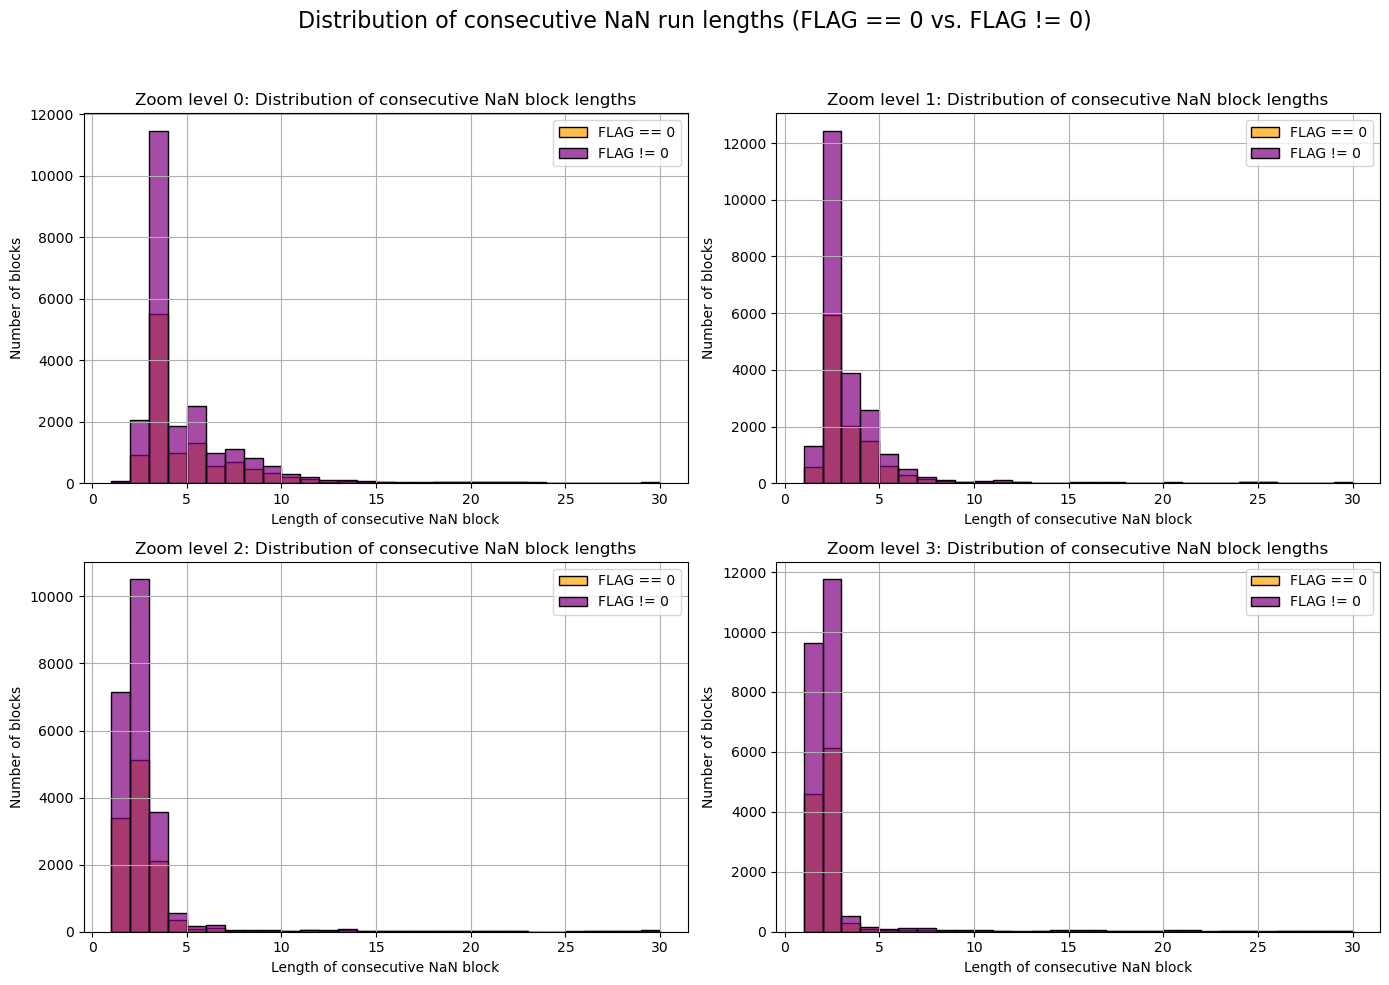

In [8]:
def get_run_lengths(bool_arr):
    diff = np.diff(np.concatenate(([0], bool_arr.astype(int), [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return ends - starts

run_lengths_flag0_by_zoom = []
run_lengths_flag_not0_by_zoom = []

for zoom in range(4):
    runs_flag0 = []
    runs_flag_not0 = []
    
    for row in filtered_spectra[zoom]:
        run_lengths = get_run_lengths(np.isnan(row))
        if run_lengths.size > 0:
            runs_flag0.extend(run_lengths)
    run_lengths_flag0_by_zoom.append(np.array(runs_flag0))
    
    for row in all_spectra[zoom]:
        run_lengths = get_run_lengths(np.isnan(row))
        if run_lengths.size > 0:
            runs_flag_not0.extend(run_lengths)
    run_lengths_flag_not0_by_zoom.append(np.array(runs_flag_not0))
    
    print(f"Zoom level {zoom} (FLAG == 0): found {len(runs_flag0)} NaN blocks, "
          f"average length = {np.mean(runs_flag0) if len(runs_flag0)>0 else 0:.2f}, "
          f"max = {np.max(runs_flag0) if len(runs_flag0)>0 else 0}")
    print(f"Zoom level {zoom} (FLAG != 0): found {len(runs_flag_not0)} NaN blocks, "
          f"average length = {np.mean(runs_flag_not0) if len(runs_flag_not0)>0 else 0:.2f}, "
          f"max = {np.max(runs_flag_not0) if len(runs_flag_not0)>0 else 0}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
bins = np.arange(1, 31)  

for i in range(4):
    ax = axes[i]
    sns.histplot(
        run_lengths_flag0_by_zoom[i],
        bins=bins,
        color="orange",
        label="FLAG == 0",
        kde=False,
        stat="count",
        alpha=0.7,
        ax=ax
    )
    sns.histplot(
        run_lengths_flag_not0_by_zoom[i],
        bins=bins,
        color="purple",
        label="FLAG != 0",
        kde=False,
        stat="count",
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"Zoom level {i}: Distribution of consecutive NaN block lengths")
    ax.set_xlabel("Length of consecutive NaN block")
    ax.set_ylabel("Number of blocks")
    ax.legend()
    ax.grid(True)

plt.suptitle("Distribution of consecutive NaN run lengths (FLAG == 0 vs. FLAG != 0)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

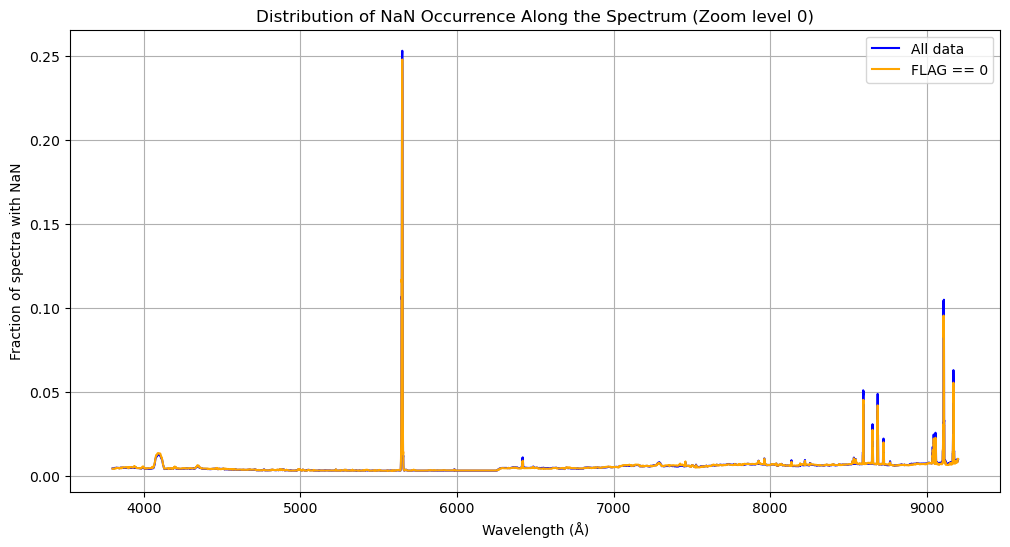

In [9]:
total_length = all_spectra[0].shape[1]
wavelengths = np.linspace(3800, 9200, total_length)

fraction_nan_all = np.mean(np.isnan(all_spectra[0]), axis=0)
fraction_nan_flag0 = np.mean(np.isnan(filtered_spectra[0]), axis=0)

plt.figure(figsize=(12,6))
plt.plot(wavelengths, fraction_nan_all, label="All data", color="blue", linewidth=1.5)
plt.plot(wavelengths, fraction_nan_flag0, label="FLAG == 0", color="orange", linewidth=1.5)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Fraction of spectra with NaN")
plt.title("Distribution of NaN Occurrence Along the Spectrum (Zoom level 0)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]

cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

cleaned_sfrs_all = sfrs_filtered.iloc[np.where(mask_clean_all)[0]]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.iloc[np.where(mask_clean_flag0)[0]]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)

print("\nCleaned All images shape (zoom 0):", cleaned_all_images[0].shape)
print("Cleaned FLAG==0 images shape (zoom 0):", cleaned_filtered_images[0].shape)

print("\nCleaned SFR (all) shape:", cleaned_sfrs_all.shape)
print("Cleaned SFR (FLAG==0) shape:", cleaned_sfrs_flag0.shape)

Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)

Cleaned All images shape (zoom 0): (20157, 5, 64, 64)
Cleaned FLAG==0 images shape (zoom 0): (11179, 5, 64, 64)

Cleaned SFR (all) shape: (20157, 284)
Cleaned SFR (FLAG==0) shape: (11179, 284)


In [11]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2, 3), keepdims=True)
        max_val = np.max(img_array, axis=(2, 3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

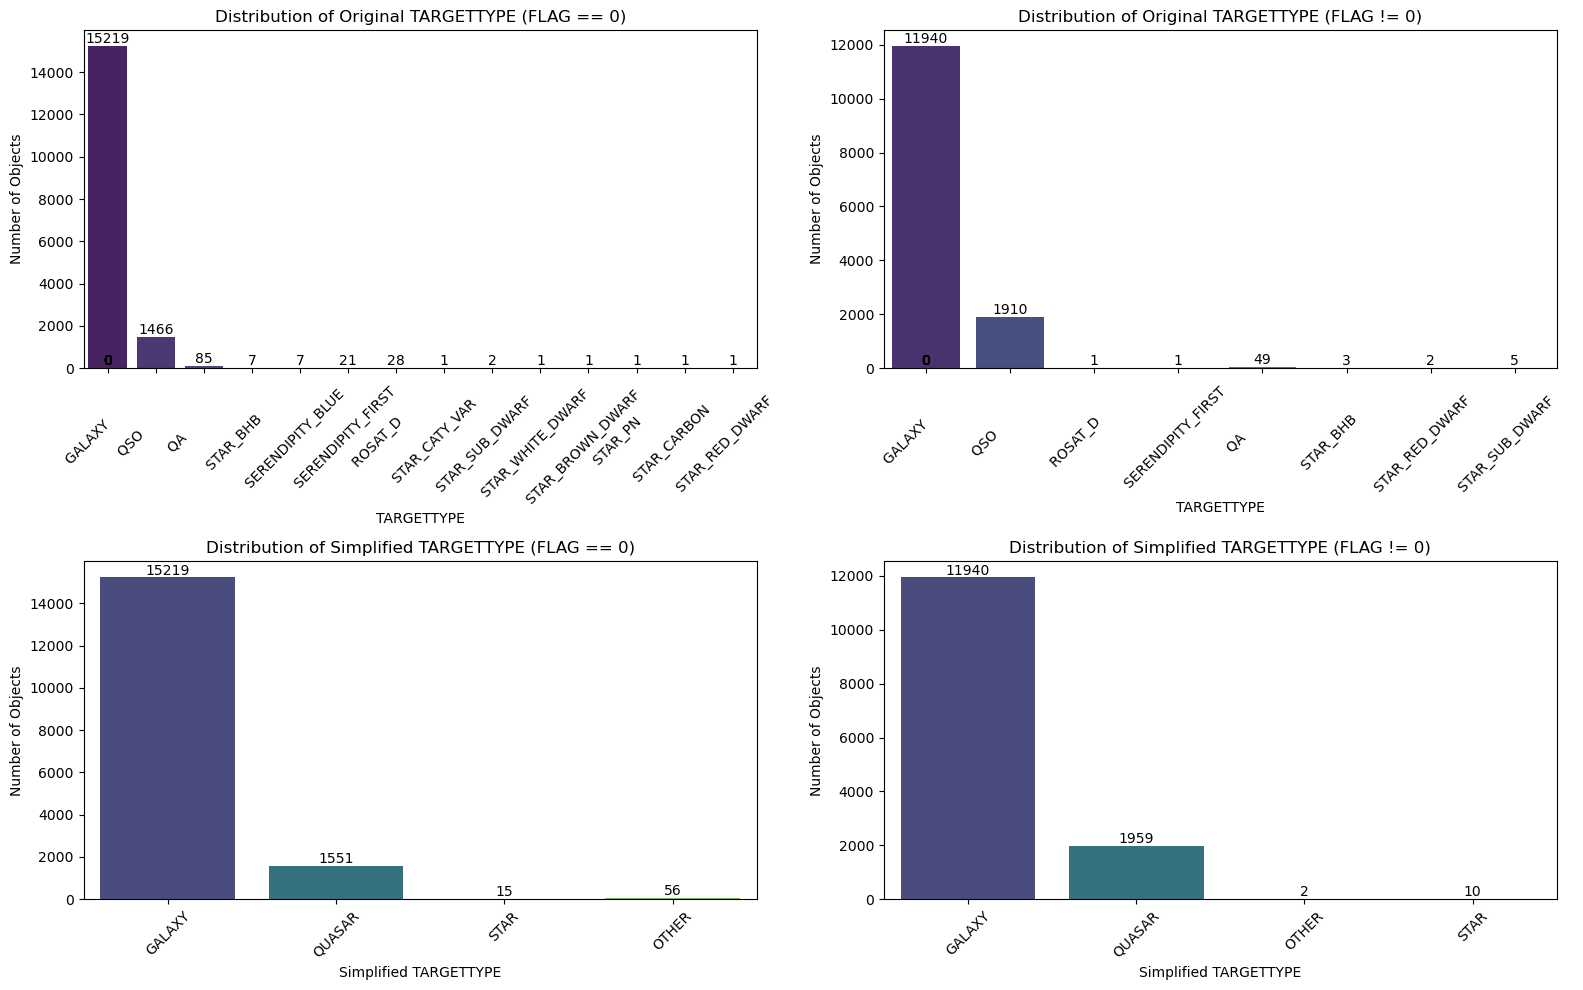

In [12]:
labels_flag0 = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]
labels_flag_not0 = sfrs_filtered.loc[sfrs_filtered["FLAG"] != 0.0, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

df_flag0_orig = pd.DataFrame({"TARGETTYPE": labels_flag0})
df_flag_not0_orig = pd.DataFrame({"TARGETTYPE": labels_flag_not0})

df_flag0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag0).apply(simplify_targettype)})
df_flag_not0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag_not0).apply(simplify_targettype)})

plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=df_flag0_orig, x="TARGETTYPE", hue="TARGETTYPE", dodge=False, palette="viridis", ax=ax1)
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
ax1.set_title("Distribution of Original TARGETTYPE (FLAG == 0)")
ax1.set_xlabel("TARGETTYPE")
ax1.set_ylabel("Number of Objects")
ax1.tick_params(axis='x', labelrotation=45)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=df_flag_not0_orig, x="TARGETTYPE", hue="TARGETTYPE", dodge=False, palette="viridis", ax=ax2)
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
ax2.set_title("Distribution of Original TARGETTYPE (FLAG != 0)")
ax2.set_xlabel("TARGETTYPE")
ax2.set_ylabel("Number of Objects")
ax2.tick_params(axis='x', labelrotation=45)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=df_flag0_simpl, x="Simplified_TARGETTYPE", hue="Simplified_TARGETTYPE", dodge=False, palette="viridis", ax=ax3)
if ax3.get_legend() is not None:
    ax3.get_legend().remove()
ax3.set_title("Distribution of Simplified TARGETTYPE (FLAG == 0)")
ax3.set_xlabel("Simplified TARGETTYPE")
ax3.set_ylabel("Number of Objects")
ax3.tick_params(axis='x', labelrotation=45)

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=df_flag_not0_simpl, x="Simplified_TARGETTYPE", hue="Simplified_TARGETTYPE", dodge=False, palette="viridis", ax=ax4)
if ax4.get_legend() is not None:
    ax4.get_legend().remove()
ax4.set_title("Distribution of Simplified TARGETTYPE (FLAG != 0)")
ax4.set_xlabel("Simplified TARGETTYPE")
ax4.set_ylabel("Number of Objects")
ax4.tick_params(axis='x', labelrotation=45)

for ax in [ax1, ax2, ax3, ax4]:
    for patch in ax.patches:
        ax.annotate(
            format(int(patch.get_height()), 'd'),
            (patch.get_x() + patch.get_width() / 2., patch.get_height()),
            ha='center', va='center', xytext=(0, 5), textcoords='offset points'
        )

plt.tight_layout()
plt.show()

In [13]:
def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val) == 0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    
    result = np.empty(len(normalized_list), dtype=object)
    for i, arr in enumerate(normalized_list):
        result[i] = arr
    return result


normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

/tmp/ipykernel_645618/2208282942.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


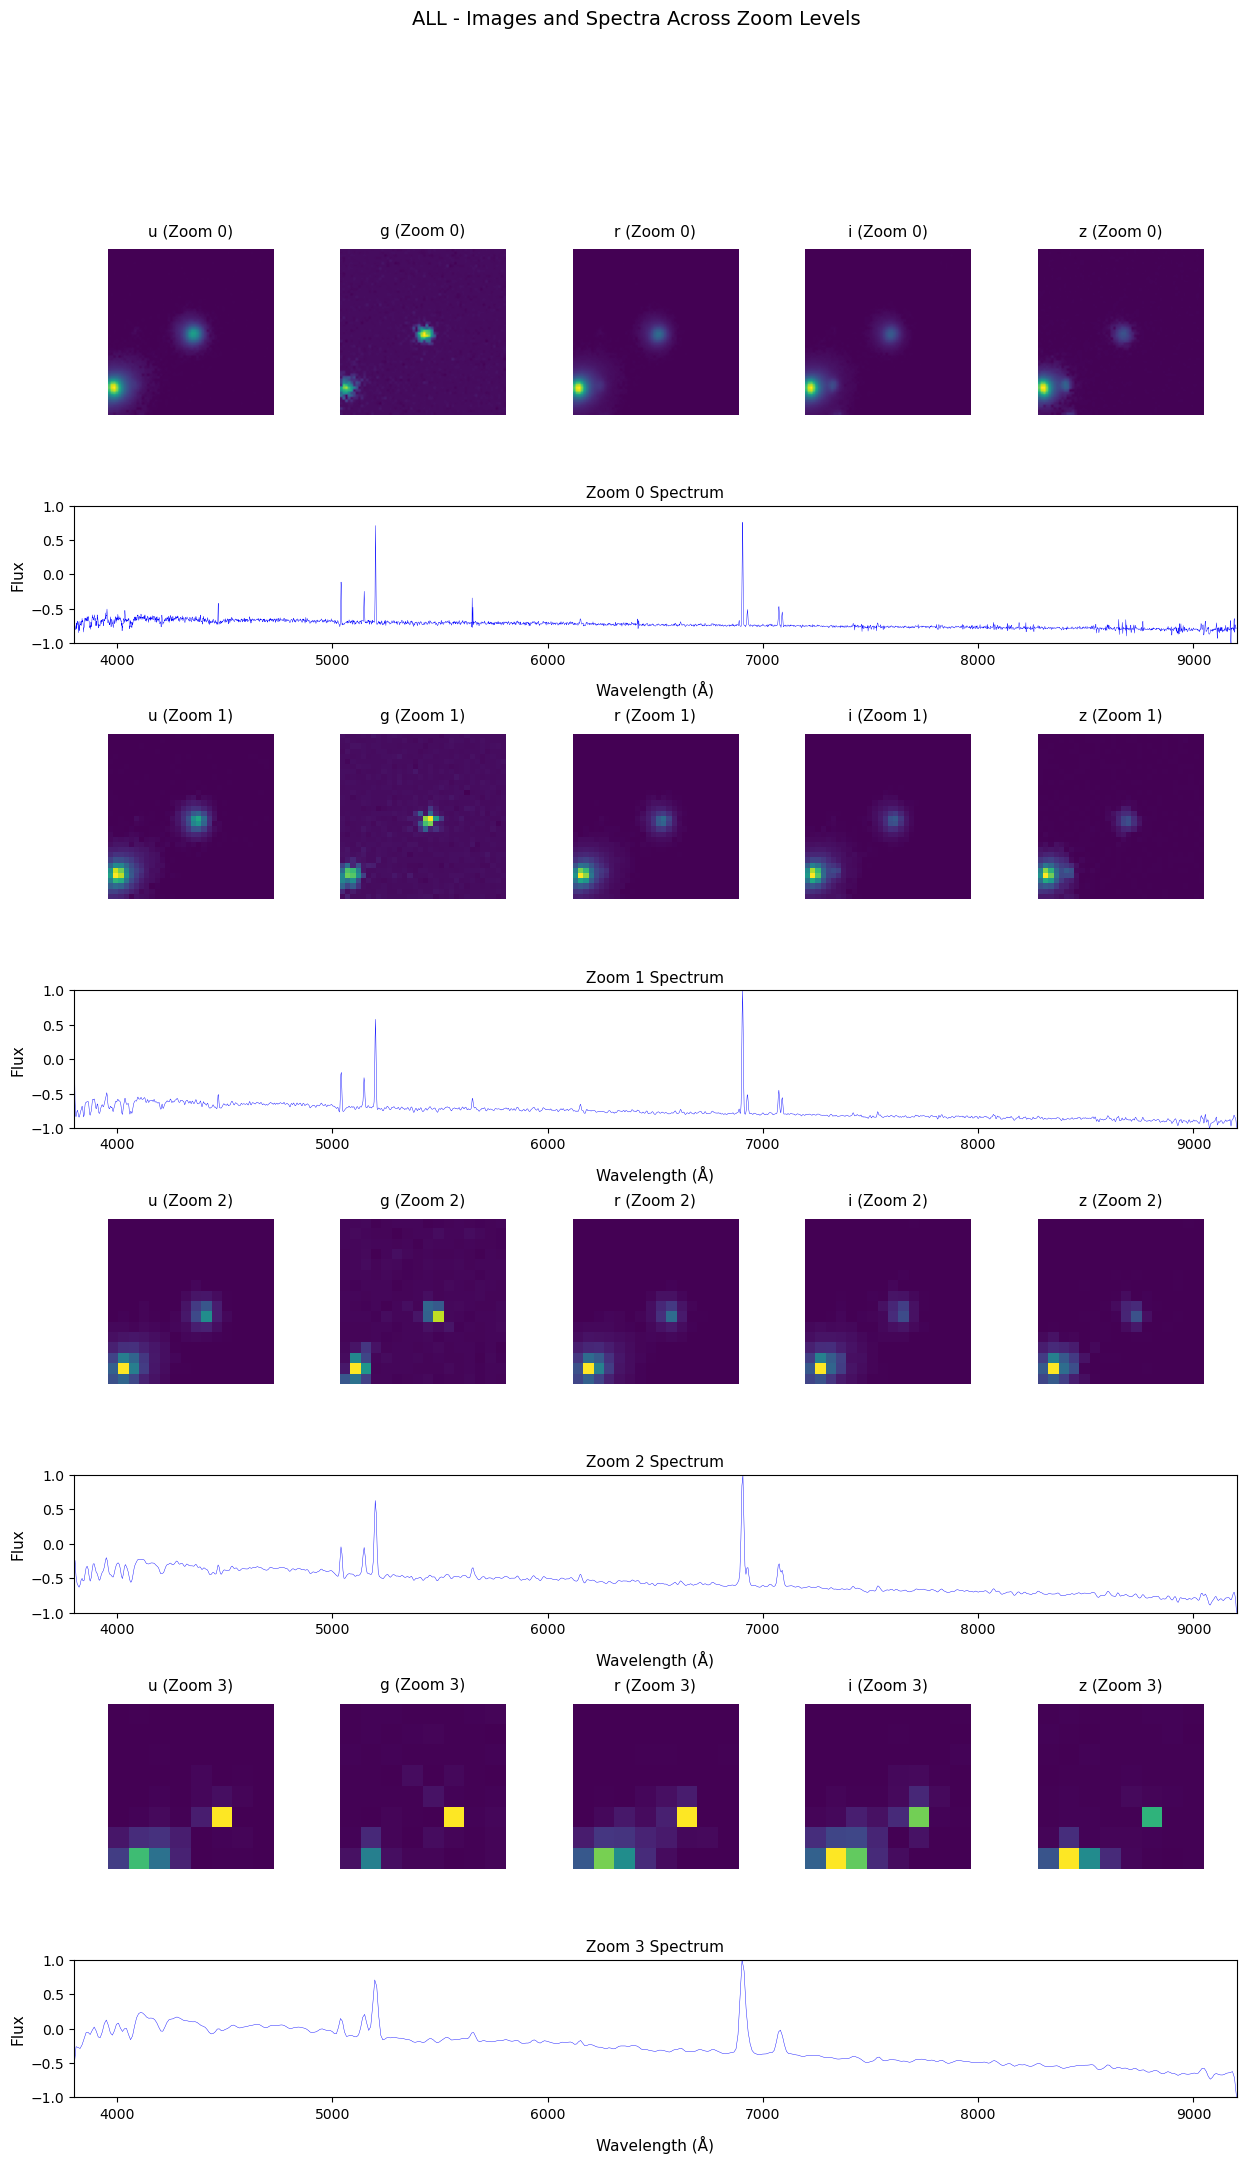

In [14]:
filters = ["u", "g", "r", "i", "z"]        

def plot_images_and_spectrum(images, spectra, labels, class_name, obj_num):
    if class_name.upper() == "ALL":
        class_index = np.arange(len(labels))
    else:
        simplified_labels = np.array([simplify_targettype(val) for val in labels])
        class_index = np.where(simplified_labels == class_name.upper())[0]
        if len(class_index) == 0:
            print(f"No images found for class: {class_name}")
            return

    if obj_num >= len(class_index):
        print(f"Object index {obj_num} is out of range. Max available: {len(class_index)-1}")
        return

    idx = class_index[obj_num]
    if len(images) < 4 or len(spectra) < 4:
        print(f"Expected 4 zoom levels, but got {len(images)} images and {len(spectra)} spectra.")
        return

    fig = plt.figure(figsize=(15, 24))
    gs = gridspec.GridSpec(8, 5, height_ratios=[1.2, 1.0, 1.2, 1.0, 1.2, 1.0, 1.2, 1.0],
                           hspace=0.6, wspace=0.0)

    for zoom in range(4):
        if idx >= images[zoom].shape[0]:
            print(f"Index {idx} is out of bounds for zoom {zoom} images.")
            continue

        img_channels = images[zoom][idx]
        spectrum = spectra[zoom][idx]

        for i in range(5):
            ax = fig.add_subplot(gs[zoom * 2, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{filters[i]} (Zoom {zoom})", fontsize=11, pad=10)
            ax.axis("off")

        ax_spec = fig.add_subplot(gs[zoom * 2 + 1, :])
        zoom_wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(zoom_wavelengths, spectrum, color="blue", linewidth=0.3)
        ax_spec.set_title(f"Zoom {zoom} Spectrum", fontsize=11)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=11, labelpad=10)
        ax_spec.set_ylabel("Flux", fontsize=11)
        ax_spec.set_xlim([3800, 9200])
        ax_spec.set_ylim([-1, 1])

    fig.suptitle(f"{class_name.upper()} - Images and Spectra Across Zoom Levels", fontsize=14)
    plt.tight_layout()
    plt.show()

for i in range(0, 1):
    plot_images_and_spectrum(cleaned_filtered_images, normalized_filtered_spectra, sfrs_filtered["TARGETTYPE"].values, "ALL", 0)

## Getting rid of photos with multiple objects:

In [15]:
flag0_indices = cleaned_sfrs_flag0.index
all_indices = cleaned_sfrs_all.index
flag_not0_indices = all_indices.difference(flag0_indices)
mask_flag_not0 = np.isin(cleaned_sfrs_all.index, flag_not0_indices)
normalized_nonflag0_images = [arr[mask_flag_not0] for arr in normalized_all_images]

In [16]:
CROP_SIZES_4 = {
    0: 32,  # originally 64
    1: 16,  # originally 32
    2: 8,   # originally 16
    3: 4    # originally 8
}
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, 
                                          max_objects=20, thumbnail_size=3, group_name="",
                                          print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
        
    # We determine the indexes of images with ≥2 objects at zoom 0 (using a channel with an index of 2)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2  
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images) * 100 if total_images > 0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]  
                wavelengths = np.linspace(3800, 9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, color="blue", linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800, 9200])
                ax_spec.set_ylim([-1, 1])
            
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, 
                                     figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
        
    return images_trimmed, multi_obj_indices

flag0_indices = cleaned_sfrs_flag0.index
all_indices = cleaned_sfrs_all.index
flag_not0_indices = all_indices.difference(flag0_indices)
mask_flag_not0 = np.isin(cleaned_sfrs_all.index, flag_not0_indices)
cleaned_nonflag0_images = [arr[mask_flag_not0] for arr in cleaned_all_images]

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


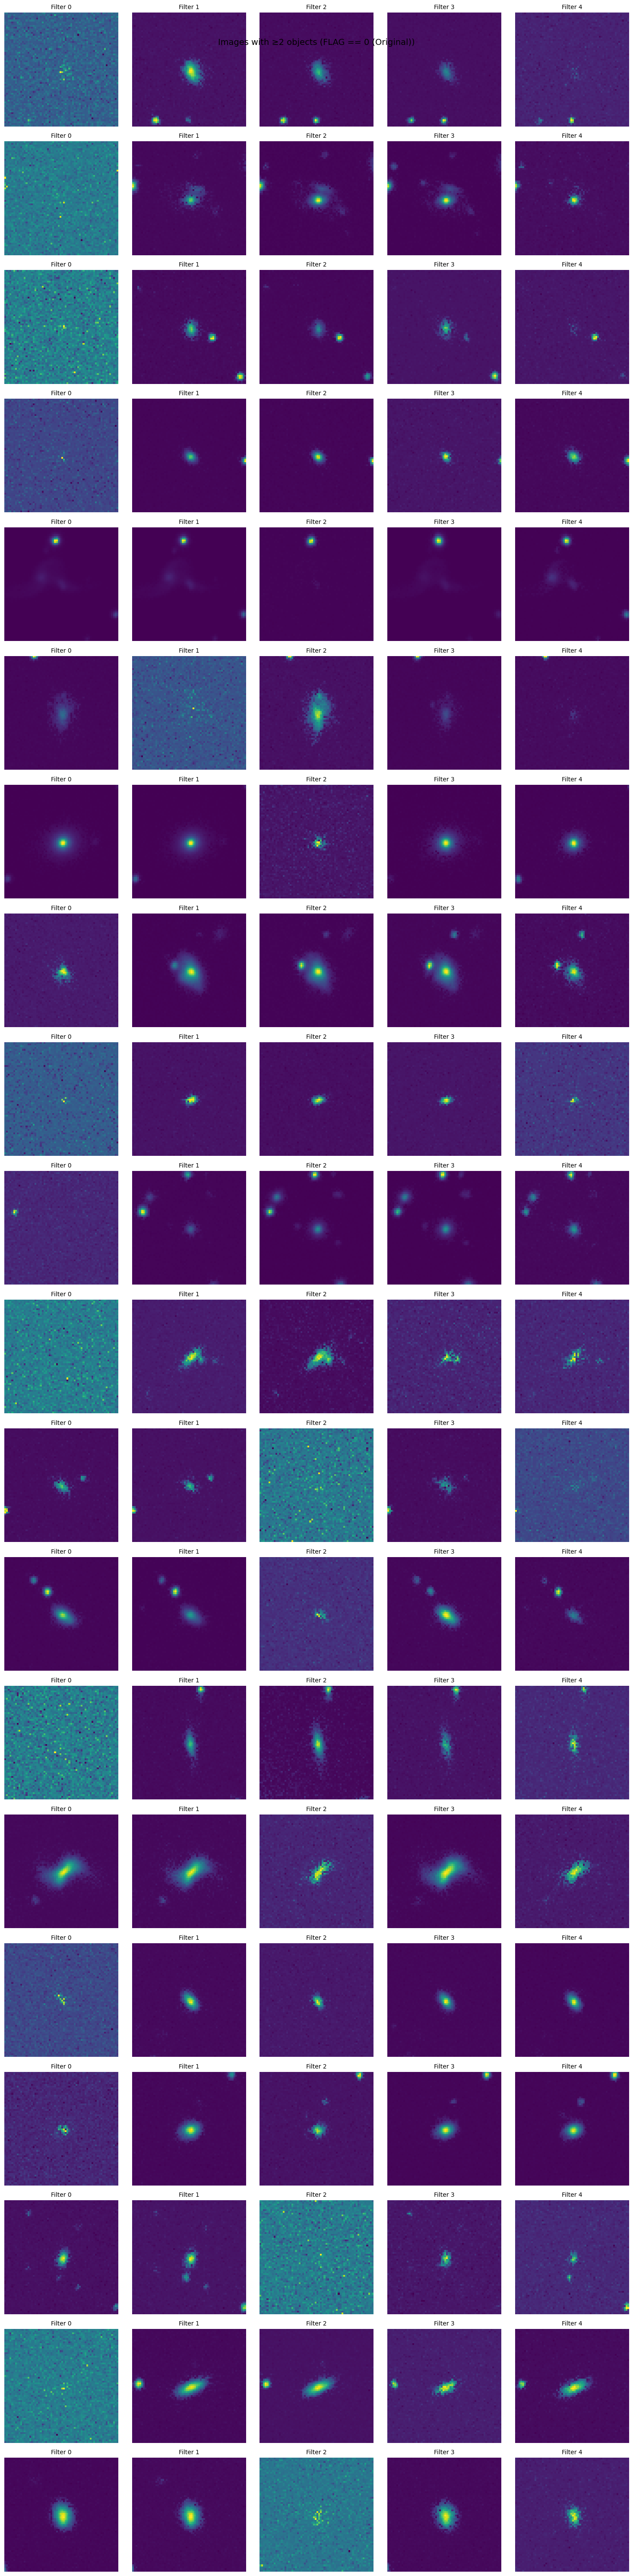

In [29]:
orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(
    normalized_filtered_images,
    thresholds=THRESHOLD,
    crop_sizes=None,
    group_name="FLAG == 0 (Original)",
    print_spectra=False,
    spectra_list=normalized_filtered_spectra
)